**Data Exploratory Analysis**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, kruskal, wilcoxon
import scipy.stats as stats
from scipy.stats import shapiro, skew, kurtosis
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
df_raw = pd.read_csv('/content/March 2023-Broadband Performance Data.csv')

In [ ]:
col_analyze = ['technology','isp','region','country','rurality','Download - 24 (ave)', 'Upload - 24 (ave)', 'Latency - 24h', 'Packet Loss - 24h','Web loading - 24h', 'Disconnections','DNS Rate - 24h']

**View Basic Structure of Data**

In [ ]:
print(df_raw[col_analyze].head())

  technology       isp                  region           country rurality  \
0      ADSL1        BT        Northern Ireland  Northern Ireland    Rural   
1      ADSL1        BT  Yorkshire & Humberside           England    Rural   
2      ADSL1        BT                   Wales             Wales    Rural   
3      ADSL1        BT                Scotland          Scotland    Rural   
4      ADSL1  TalkTalk                Scotland          Scotland    Rural   

   Download - 24 (ave)  Upload - 24 (ave)  Latency - 24h  Packet Loss - 24h  \
0             2.886062           0.364627      40.483235           0.000512   
1             5.017943           0.368227      30.169321           0.000127   
2             2.798633           0.359128      50.872788           0.003041   
3             1.994802           0.374817      40.170209           0.000548   
4             0.806190           0.546933      43.121419           0.000426   

   Web loading - 24h  Disconnections  DNS Rate - 24h  
0      

In [ ]:
print(df_raw[col_analyze].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2645 entries, 0 to 2644
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   technology           2645 non-null   object 
 1   isp                  2645 non-null   object 
 2   region               2645 non-null   object 
 3   country              2645 non-null   object 
 4   rurality             2645 non-null   object 
 5   Download - 24 (ave)  2426 non-null   float64
 6   Upload - 24 (ave)    2644 non-null   float64
 7   Latency - 24h        2645 non-null   float64
 8   Packet Loss - 24h    2645 non-null   float64
 9   Web loading - 24h    2645 non-null   float64
 10  Disconnections       2576 non-null   float64
 11  DNS Rate - 24h       2645 non-null   float64
dtypes: float64(7), object(5)
memory usage: 248.1+ KB
None


**Data Cleaning**

In [ ]:
# Drop columns with 30% missing values
threshold = 0.3 * len(df_raw)
df = df_raw.dropna(thresh=threshold, axis=1)

# Impute missing values with median
numerical_cols = ['Download - 24 (ave)', 'Upload - 24 (ave)', 'Latency - 24h', 'Packet Loss - 24h','Web loading - 24h', 'Disconnections','DNS Rate - 24h']
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Flag missing categorical values
df['rurality_missing'] = df['rurality'].isnull().astype(int)
df['rurality'].fillna('Unknown', inplace=True)
df['region_missing'] = df['region'].isnull().astype(int)
df['region'].fillna('Unknown', inplace=True)
df['technology_missing'] = df['technology'].isnull().astype(int)
df['technology'].fillna('Unknown', inplace=True)
df['isp_missing'] = df['isp'].isnull().astype(int)
df['isp'].fillna('Unknown', inplace=True)
df['country_missing'] = df['country'].isnull().astype(int)
df['country'].fillna('Unknown', inplace=True)


<ipython-input-51-b7423320fd70>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-51-b7423320fd70>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-51-b7423320fd70>:12: FutureWarning: A value is trying to be set on a copy 

In [ ]:
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

for col in numerical_cols:
    df = cap_outliers(df, col)

In [ ]:
df

,panel,allocation_type,isp,technology,package_download_speed,package_upload_speed,market_classification,max_attainable_mbps,region,country,...,NetflixPeak,package_for_weighting,national_weight,rural_weight,isp_weight,rurality_missing,region_missing,technology_missing,isp_missing,country_missing
0,ofcom,no_validation,BT,ADSL1,8.0,1.0,B,NaN,Northern Ireland,Northern Ireland,...,36.0,BT 10 ADSL1,0.0336,0.0596,0.45,0,0,0,0,0
1,ofcom,validation,BT,ADSL1,8.0,1.0,B,NaN,Yorkshire & Humberside,England,...,54.0,BT 10 ADSL1,0.1132,0.0545,2.10,0,0,0,0,0
2,ukindustry,validation,BT,ADSL1,8.0,1.0,B,NaN,Wales,Wales,...,56.0,BT 10 ADSL1,0.0137,0.0348,0.45,0,0,0,0,0
3,ofcom,validation,BT,ADSL1,8.0,1.0,B,NaN,Scotland,Scotland,...,57.0,BT 10 ADSL1,0.0173,0.0302,0.45,0,0,0,0,0
4,ukindustry,no_validation,TalkTalk,ADSL1,8.0,1.0,A,NaN,Scotland,Scotland,...,56.0,TalkTalk 10 ADSL1,0.0023,0.0011,NaN,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2640,ukindustry,no_validation,Starlink,Satellite,NaN,NaN,B,NaN,Scotland,Scotland,...,0.0,Starlink Satellite,NaN,NaN,NaN,0,0,0,0,0
2641,ukindustry,no_validation,Starlink,Satellite,NaN,NaN,B,NaN,Scotland,Scotland,...,0.0,Starlink Satellite,NaN,NaN,NaN,0,0,0,0,0
2642,ukindustry,no_validation,Starlink,Satellite,NaN,NaN,B,NaN,Scotland,Scotland,...,0.0,Starlink Satellite,NaN,NaN,NaN,0,0,0,0,0
2643,ukindustry,no_validation,Starlink,Satellite,NaN,NaN,B,NaN,West Midlands,England,...,0.0,Starlink Satellite,NaN,NaN,NaN,0,0,0,0,0


In [ ]:
print(df[col_analyze].duplicated().sum())

0


**Statistical** **Analysis**

In [ ]:
#summary statistics of the required columns
df[col_analyze].describe()

,Download - 24 (ave),Upload - 24 (ave),Latency - 24h,Packet Loss - 24h,Web loading - 24h,Disconnections,DNS Rate - 24h
count,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000
mean,110.673495,25.100552,12.314528,0.000399,242.877890,0.189132,14.961009
std,100.888825,20.947489,5.805560,0.000450,162.466917,0.161513,6.252476
min,0.721365,0.264228,1.133063,0.000000,42.245960,0.000000,1.924103
25%,39.026773,9.260998,8.028065,0.000062,129.024756,0.064516,10.760207
50%,69.314678,18.540429,11.228300,0.000192,184.672616,0.129032,13.740180
75%,147.244858,34.560568,15.495283,0.000595,346.928972,0.250000,18.261344
max,309.571985,72.509924,26.696111,0.001395,673.785297,0.528226,29.513050


In [ ]:
numeric_col = ['Download - 24 (ave)', 'Upload - 24 (ave)', 'Latency - 24h', 'Packet Loss - 24h','Web loading - 24h', 'Disconnections','DNS Rate - 24h']
skewness_values = stats.skew(df[numeric_col], nan_policy='omit', axis=0) # Calculate along columns (axis=0)
for col, skewness in zip(numeric_col, skewness_values):
    print(f"Skewness of {col}: {skewness}")
Kurtosis_values = stats.kurtosis(df[numeric_col], nan_policy='omit', axis=0) # Calculate along columns (axis=0)
for col, kurtos in zip(numeric_col, Kurtosis_values):
    print(f"Kurtosis of {col}: {kurtos}")

Skewness of Download - 24 (ave): 1.1588420915255906
Skewness of Upload - 24 (ave): 1.175366421084791
Skewness of Latency - 24h: 0.7813499658456647
Skewness of Packet Loss - 24h: 1.2073674631401243
Skewness of Web loading - 24h: 1.271634628843245
Skewness of Disconnections: 1.1267381113145107
Skewness of DNS Rate - 24h: 0.7433009580220624
Kurtosis of Download - 24 (ave): -0.2565100707537442
Kurtosis of Upload - 24 (ave): 0.3079319739536084
Kurtosis of Latency - 24h: 0.2138302147578317
Kurtosis of Packet Loss - 24h: 0.12052662820284477
Kurtosis of Web loading - 24h: 0.8738801373898766
Kurtosis of Disconnections: -0.00756058173363483
Kurtosis of DNS Rate - 24h: 0.07058678289832354


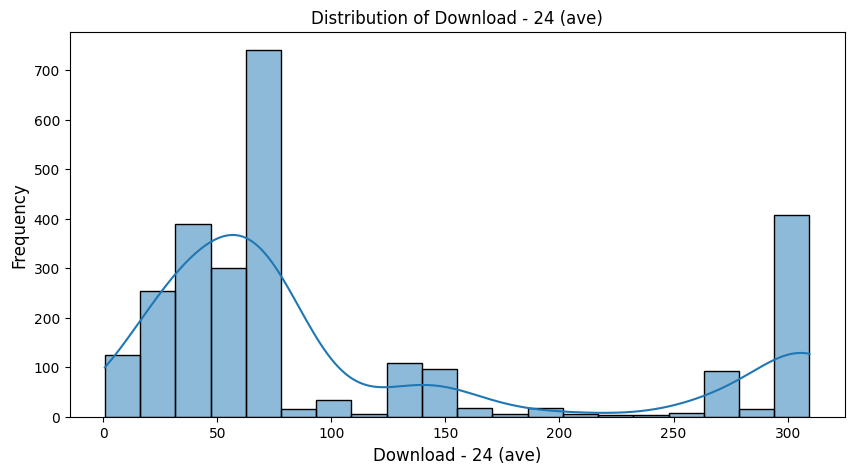

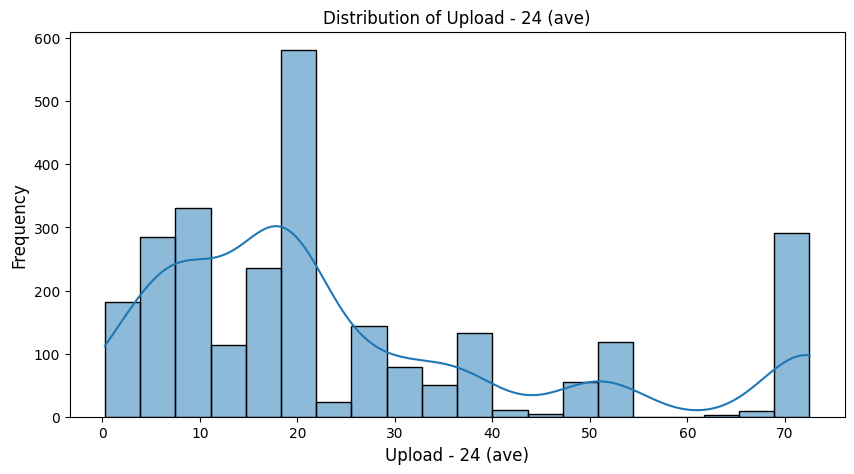

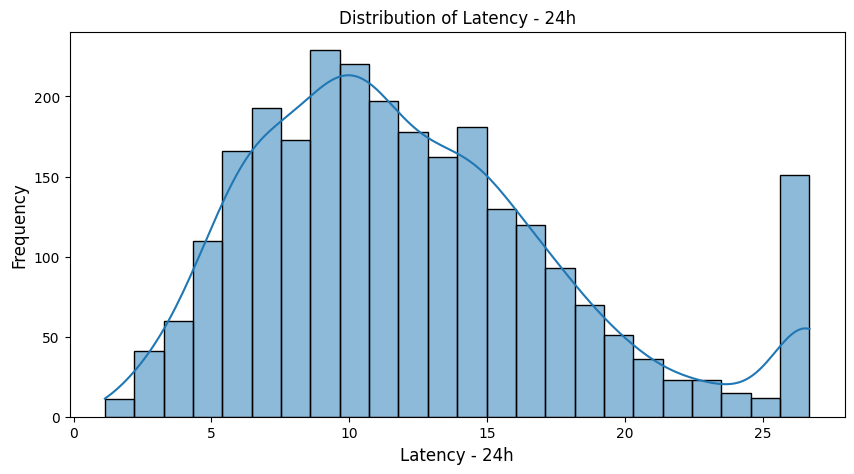

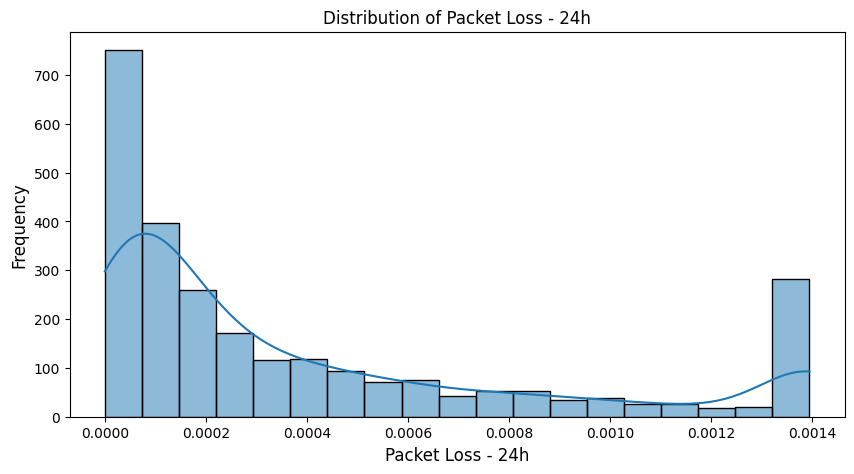

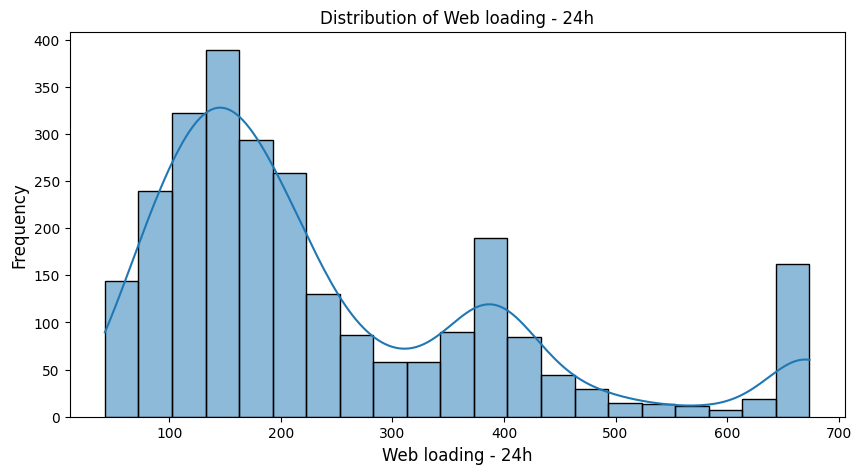

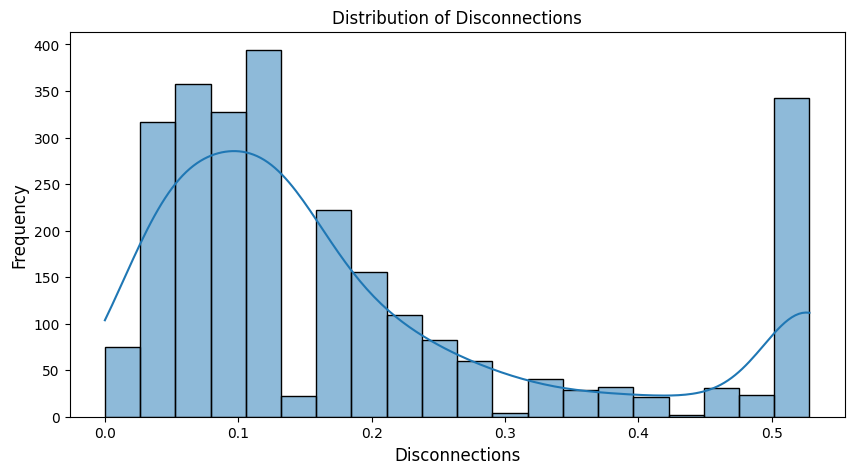

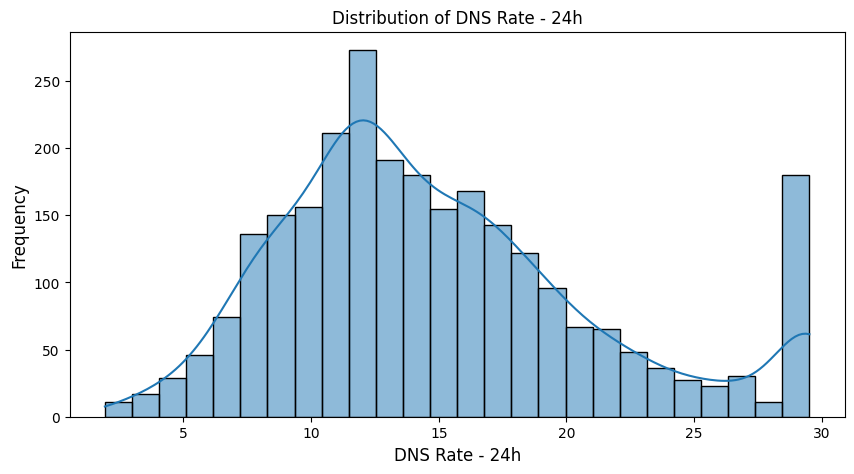

In [ ]:
for col in numeric_col:
    plt.figure(figsize=(10, 5))

    # Histogram
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.show()


In [ ]:
print('Shapiro-Wilk Normality Test\n')
for col in numeric_col:
    stat, p_value = shapiro(df[col], nan_policy='omit')
    print(f"{col} Stat={stat}, p-value={p_value}")

    if p_value < 0.05:
        print(f"--> {col} is not normally distributed\n")
    else:
        print(f"--> {col} is normally distributed\n")

Shapiro-Wilk Normality Test

Download - 24 (ave) Stat=0.7508968133406069, p-value=6.300328341732394e-53
--> Download - 24 (ave) is not normally distributed

Upload - 24 (ave) Stat=0.8330306220872175, p-value=2.6021989488450427e-46
--> Upload - 24 (ave) is not normally distributed

Latency - 24h Stat=0.944817776702311, p-value=2.216836146310771e-30
--> Latency - 24h is not normally distributed

Packet Loss - 24h Stat=0.7845901901847087, p-value=1.801016499075675e-50
--> Packet Loss - 24h is not normally distributed

Web loading - 24h Stat=0.8496403930476455, p-value=1.1821820752697933e-44
--> Web loading - 24h is not normally distributed

Disconnections Stat=0.8165352441756895, p-value=7.914358577605682e-48
--> Disconnections is not normally distributed

DNS Rate - 24h Stat=0.9434811297645553, p-value=1.0921802628853786e-30
--> DNS Rate - 24h is not normally distributed



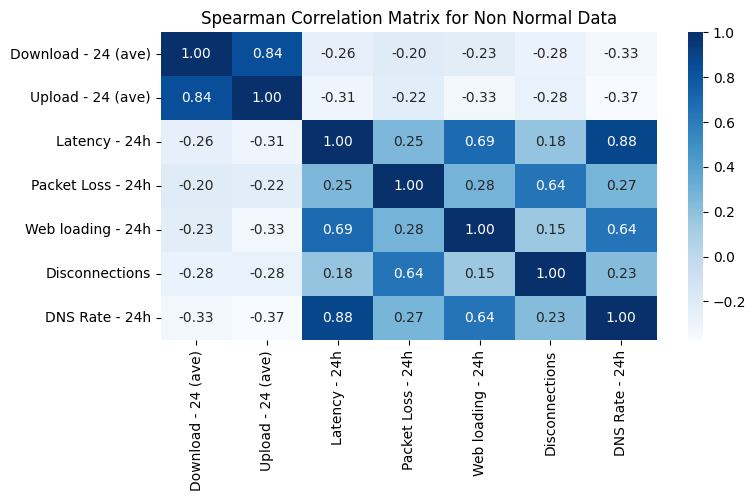

In [ ]:
spearman_corr = df[numeric_col].corr(method='spearman')

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(spearman_corr, annot=True, cmap='Blues', fmt=".2f")
plt.title('Spearman Correlation Matrix for Non Normal Data')
plt.show()

In [ ]:
p_values = df[numeric_col].corr(method=lambda x, y: stats.spearmanr(x, y)[1])
# Display both correlation coefficients and p-values
print("\nP-Values Matrix:\n", p_values)


P-Values Matrix:
                      Download - 24 (ave)  Upload - 24 (ave)  Latency - 24h  \
Download - 24 (ave)         1.000000e+00       0.000000e+00   3.120274e-42   
Upload - 24 (ave)           0.000000e+00       1.000000e+00   2.520617e-61   
Latency - 24h               3.120274e-42       2.520617e-61   1.000000e+00   
Packet Loss - 24h           7.156509e-26       2.735048e-30   5.304501e-40   
Web loading - 24h           5.742106e-32       5.747566e-70   0.000000e+00   
Disconnections              1.368741e-48       1.843711e-47   9.586087e-20   
DNS Rate - 24h              5.361146e-69       2.790042e-88   0.000000e+00   

                     Packet Loss - 24h  Web loading - 24h  Disconnections  \
Download - 24 (ave)       7.156509e-26       5.742106e-32    1.368741e-48   
Upload - 24 (ave)         2.735048e-30       5.747566e-70    1.843711e-47   
Latency - 24h             5.304501e-40       0.000000e+00    9.586087e-20   
Packet Loss - 24h         1.000000e+00       7.7

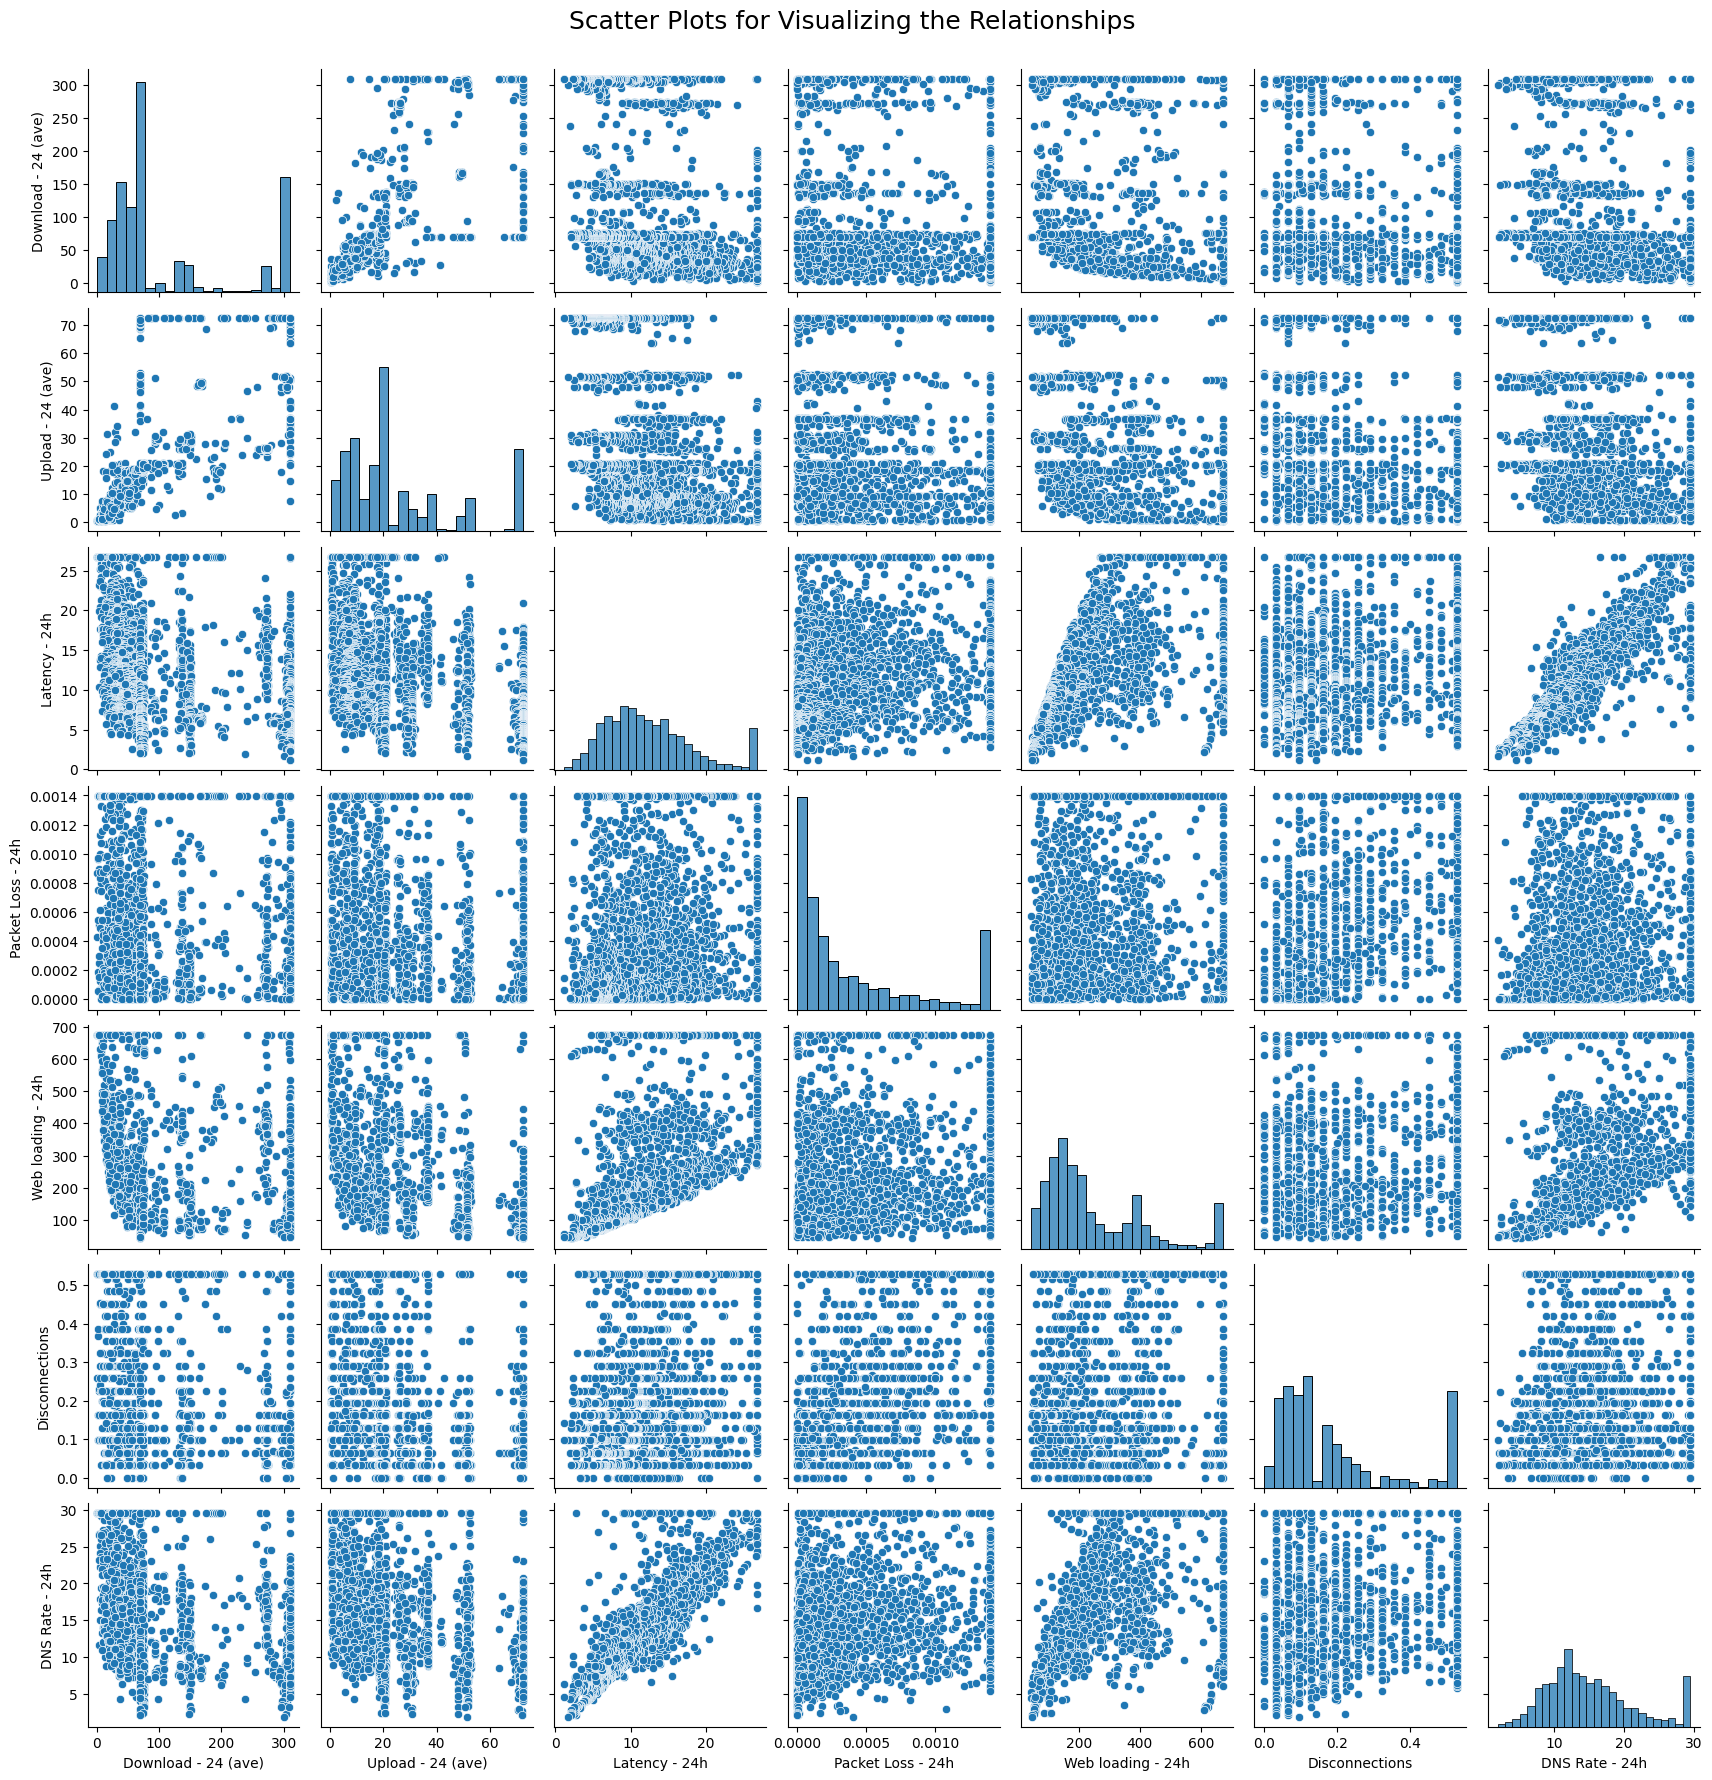

In [ ]:
sns.pairplot(df[numeric_col])
plt.suptitle('Scatter Plots for Visualizing the Relationships',y=1.02, fontsize=18)
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 14
plt.show()

In [ ]:
# Compare latency by rurality (urban vs. rural)
urban = df[df['rurality'] == 'Urban']['Latency - 24h']
rural = df[df['rurality'] == 'Rural']['Latency - 24h']
stat, p = mannwhitneyu(urban, rural)
print(f"Mann-Whitney U Test (Urban vs. Rural Latency): p = {p:.4f}")

# Rank-biserial correlation for calculating effect size
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(urban, rural)
r = abs(stat / (len(urban) * len(rural)) - 0.5) * 2
print(f"Effect size (r): {r:.2f}")

Mann-Whitney U Test (Urban vs. Rural Latency): p = 0.0380
Effect size (r): 0.05


In [ ]:
# Compare latency by technology (fttc and cable)
cable = df[df['technology'] == 'Cable']['Latency - 24h']
fttc = df[df['technology'] == 'FTTC']['Latency - 24h']
stat, p = mannwhitneyu(cable, fttc)
print(f"Mann-Whitney U Test (Cable vs. FTTC Latency): p = {p:.4f}")

# Rank-biserial correlation for calculating effect size
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(cable, fttc)
r = abs(stat / (len(cable) * len(fttc)) - 0.5) * 2
print(f"Effect size (r): {r:.2f}")

Mann-Whitney U Test (Cable vs. FTTC Latency): p = 0.0000
Effect size (r): 0.31


In [ ]:
print(f"Urban median latency: {urban.median():.2f} ms")
print(f"Rural median latency: {rural.median():.2f} ms")
print(f"Urban samples: {len(urban)}")
print(f"Rural samples: {len(rural)}")

Urban median latency: 11.27 ms
Rural median latency: 11.19 ms
Urban samples: 1960
Rural samples: 685


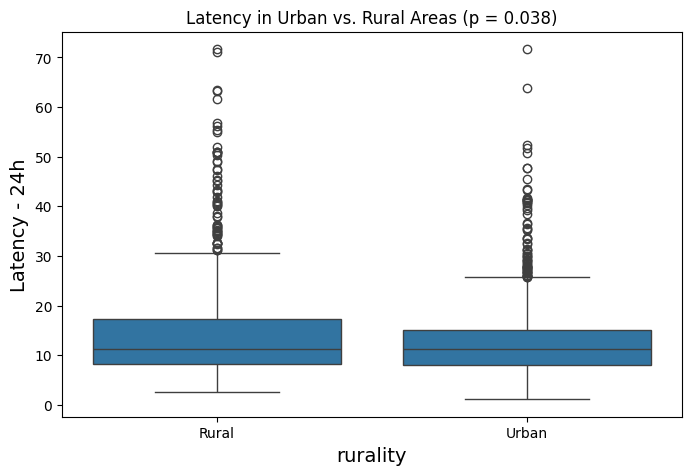

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_raw, x='rurality', y='Latency - 24h')
plt.title("Latency in Urban vs. Rural Areas (p = 0.038)")
plt.show()

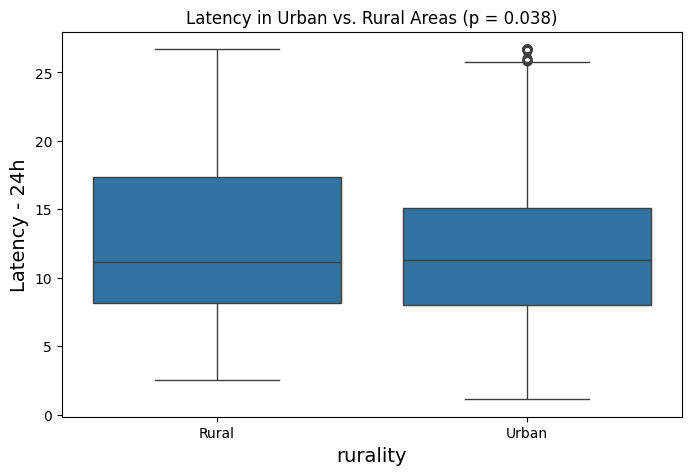

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='rurality', y='Latency - 24h')
plt.title("Latency in Urban vs. Rural Areas (p = 0.038)")
plt.show()

In [ ]:
#Compare Latency by Rurality WITHIN EACH TECHNOLOGY
technologies = ['Cable', 'FTTC', 'FTTP', 'ADSL1', 'ADSL2+', 'GFAST','Satellite', 'Fixed Wireless', 'SOGFAST']  # Replace with your actual technology categories

for tech in technologies:
    tech_subset = df[df['technology'] == tech]
    urban_latency = tech_subset[tech_subset['rurality'] == 'Urban']['Latency - 24h']
    rural_latency = tech_subset[tech_subset['rurality'] == 'Rural']['Latency - 24h']

    if len(urban_latency) > 20 and len(rural_latency) > 20:
        stat, p = mannwhitneyu(urban_latency, rural_latency)
        r = abs(stat / (len(urban_latency) * len(rural_latency)) - 0.5) * 2

        print(f"\n--- {tech} Technology ---")
        print(f"Urban Median Latency: {urban_latency.median():.2f} ms")
        print(f"Rural Median Latency: {rural_latency.median():.2f} ms")
        print(f"Mann-Whitney U p-value: {p:.4f}")
        print(f"Effect size (r): {r:.2f}")
    else:
        print(f"\n--- {tech} Technology ---")
        print("Insufficient sample size for comparison.")


#Compare Latency by Rurality WITHIN EACH ISP

isps = df['isp'].unique()

for isp in isps:
    isp_subset = df[df['isp'] == isp]
    urban_latency = isp_subset[isp_subset['rurality'] == 'Urban']['Latency - 24h']
    rural_latency = isp_subset[isp_subset['rurality'] == 'Rural']['Latency - 24h']

    if len(urban_latency) > 20 and len(rural_latency) > 20:
        stat, p = mannwhitneyu(urban_latency, rural_latency)
        r = abs(stat / (len(urban_latency) * len(rural_latency)) - 0.5) * 2

        print(f"\n--- ISP: {isp} ---")
        print(f"Urban Median Latency: {urban_latency.median():.2f} ms")
        print(f"Rural Median Latency: {rural_latency.median():.2f} ms")
        print(f"Mann-Whitney U p-value: {p:.4f}")
        print(f"Effect size (r): {r:.2f}")
    else:
        print(f"\n--- ISP: {isp} ---")
        print("Insufficient sample size for comparison.")


--- Cable Technology ---
Insufficient sample size for comparison.

--- FTTC Technology ---
Urban Median Latency: 10.96 ms
Rural Median Latency: 11.31 ms
Mann-Whitney U p-value: 0.0130
Effect size (r): 0.09

--- FTTP Technology ---
Urban Median Latency: 6.59 ms
Rural Median Latency: 6.94 ms
Mann-Whitney U p-value: 0.4373
Effect size (r): 0.04

--- ADSL1 Technology ---
Insufficient sample size for comparison.

--- ADSL2+ Technology ---
Urban Median Latency: 25.33 ms
Rural Median Latency: 26.70 ms
Mann-Whitney U p-value: 0.2659
Effect size (r): 0.14

--- GFAST Technology ---
Insufficient sample size for comparison.

--- Satellite Technology ---
Insufficient sample size for comparison.

--- Fixed Wireless Technology ---
Urban Median Latency: 26.70 ms
Rural Median Latency: 26.70 ms
Mann-Whitney U p-value: 0.7405
Effect size (r): 0.03

--- SOGFAST Technology ---
Insufficient sample size for comparison.

--- ISP: BT ---
Urban Median Latency: 8.78 ms
Rural Median Latency: 10.76 ms
Mann-Whitne

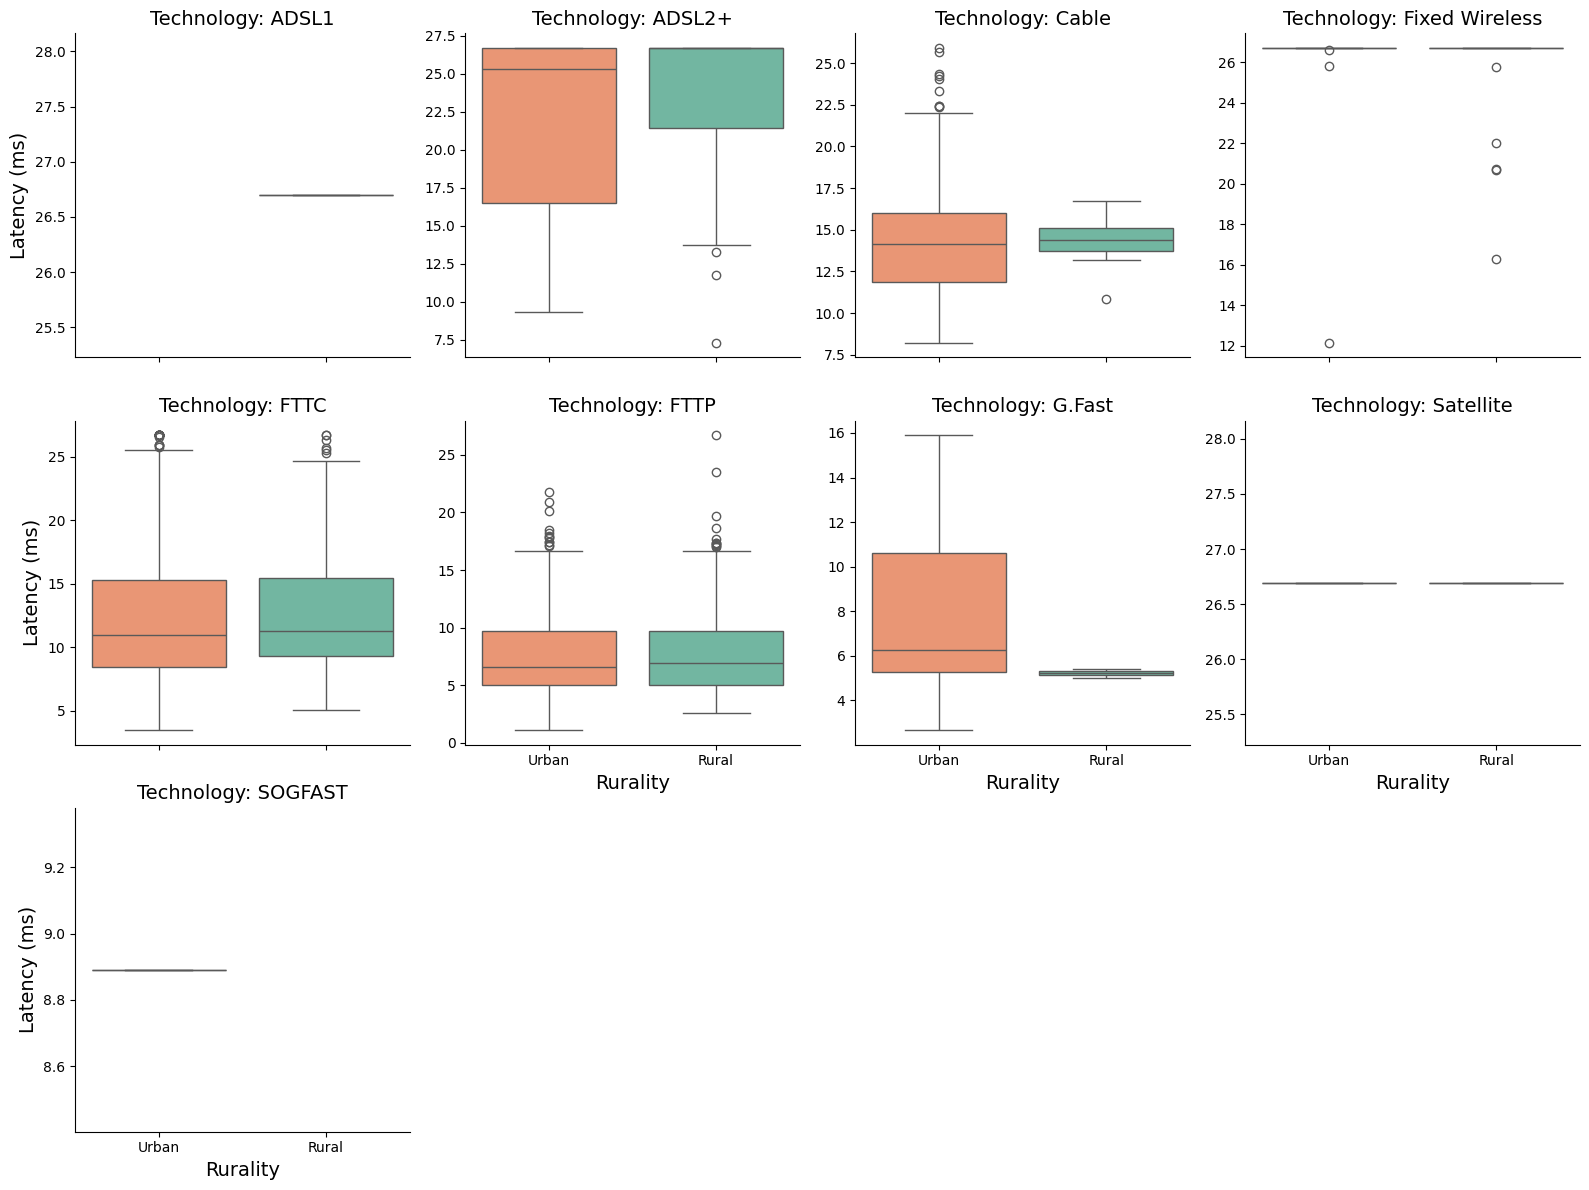

In [ ]:
g = sns.FacetGrid(df, col='technology', col_wrap=4, height=4, sharey=False)
g.map(sns.boxplot, 'rurality', 'Latency - 24h', order=['Urban', 'Rural'],hue=df['rurality'], palette='Set2', legend=False)
g.set_titles("Technology: {col_name}")
g.set_axis_labels("Rurality", "Latency (ms)")
plt.show()

In [ ]:
Latency_Gap = rural_latency - urban_latency
df.to_csv('cleaned_network_data.csv', index=False)

In [ ]:
df = pd.read_csv('cleaned_network_data.csv')

#Add Latency Gap (Rural - Urban) for Each ISP
# Calculate median latency for urban/rural groups per ISP
urban_median = df[df['rurality'] == 'Urban'].groupby('isp')['Latency - 24h'].median().rename('urban_median_latency')
rural_median = df[df['rurality'] == 'Rural'].groupby('isp')['Latency - 24h'].median().rename('rural_median_latency')

# Merge medians into main dataframe
df = df.merge(urban_median, on='isp', how='left')
df = df.merge(rural_median, on='isp', how='left')

# Calculate latency gap
df['latency_gap'] = df['rural_median_latency'] - df['urban_median_latency']

# 2. Add p-value and Effect Size for Each ISP

def calculate_isp_stats(isp_group):
    """Calculate Mann-Whitney U test stats for an ISP group."""
    urban = isp_group[isp_group['rurality'] == 'Urban']['Latency - 24h']
    rural = isp_group[isp_group['rurality'] == 'Rural']['Latency - 24h']

    if len(urban) >= 20 and len(rural) >= 20:  # Minimum sample size threshold
        stat, p = mannwhitneyu(urban, rural)
        n1, n2 = len(urban), len(rural)
        r = abs(stat / (n1 * n2) - 0.5) * 2  # Rank-biserial correlation
        return pd.Series({'isp_p_value': p, 'isp effect_size': r})
    else:
        return pd.Series({'isp_p_value': None, 'isp effect_size': None})

# Calculate stats for each ISP
isp_stats = df.groupby('isp').apply(calculate_isp_stats).reset_index()

# Merge stats back into main dataframe
df = df.merge(isp_stats, on='isp', how='left')

#Repeat for Technology
def calculate_tech_stats(tech_group):
    """Calculate stats for technology groups."""
    urban = tech_group[tech_group['rurality'] == 'Urban']['Latency - 24h']
    rural = tech_group[tech_group['rurality'] == 'Rural']['Latency - 24h']

    if len(urban) >= 20 and len(rural) >= 20:
        stat, p = mannwhitneyu(urban, rural)
        n1, n2 = len(urban), len(rural)
        r = abs(stat / (n1 * n2) - 0.5) * 2
        return pd.Series({'tech_p_value': p, 'tech_effect_size': r})
    else:
        return pd.Series({'tech_p_value': None, 'tech_effect_size': None})

tech_stats = df.groupby('technology').apply(calculate_tech_stats).reset_index()
df = df.merge(tech_stats, on='technology', how='left')

# Cleanup & Save
# Drop intermediate columns
df.drop(['urban_median_latency', 'rural_median_latency'], axis=1, inplace=True)

# Save updated dataset
df.to_csv('enhanced_network_data.csv', index=False)

<ipython-input-46-a8cafda77562>:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  isp_stats = df.groupby('isp').apply(calculate_isp_stats).reset_index()
<ipython-input-46-a8cafda77562>:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tech_stats = df.groupby('technology').apply(calculate_tech_stats).reset_index()
